In [2]:
!pip install -q pandas kagglehub numpy scipy matplotlib scikit-learn ipykernel jupyter pytest nltk 

In [3]:
import kagglehub
import pandas as pd
import os

In [4]:
# Download latest version
path = kagglehub.dataset_download("arshkon/linkedin-job-postings")
df = pd.read_csv(os.path.join(path,"postings.csv"))

### EDA

In [5]:
df.shape

(123849, 31)

In [6]:
df["location"].value_counts().head()

location
United States    8125
New York, NY     2756
Chicago, IL      1834
Houston, TX      1762
Dallas, TX       1383
Name: count, dtype: int64

In [7]:
yearly_df = df[df["pay_period"] == "YEARLY"].shape

In [8]:
ny_df = df[df["location"] == "New York, NY"].reset_index()

In [9]:
ny_df["pay_period"].value_counts().head()

pay_period
YEARLY     1201
HOURLY      307
MONTHLY       2
WEEKLY        2
Name: count, dtype: int64

In [10]:
ny_df.shape

(2756, 32)

In [11]:
us_df = df[df["location"] == "United States"]

In [12]:
us_df.shape

(8125, 31)

### Cleaning

In [13]:
[c for c in ny_df.columns if "salary" in c]

['max_salary', 'med_salary', 'min_salary', 'normalized_salary']

In [14]:
ny_df[ny_df["max_salary"].notna()].shape

(1371, 32)

In [15]:
ny_df[ny_df["min_salary"].notna()].shape

(1371, 32)

In [16]:
ny_df[ny_df["med_salary"].notna()].shape

(141, 32)

In [17]:
ny_df[ny_df["max_salary"].notna() & ny_df["min_salary"].notna()].shape

(1371, 32)

#### Drop NaN values and non USD

In [18]:
salary_df = df[df["max_salary"].notna() & df["min_salary"].notna() & df["description"].notna()]

In [19]:
salary_df["min_salary"]

0             17.0
1             30.0
2          45000.0
3         140000.0
4          60000.0
            ...   
123837        35.0
123839     50000.0
123843        30.0
123844    120000.0
123848     70000.0
Name: min_salary, Length: 29792, dtype: float64

In [20]:
salary_ny_df = ny_df[ny_df["max_salary"].notna() & ny_df["min_salary"].notna()]

#### Annualize Salary

In [21]:
salary_df["pay_period"].value_counts()

pay_period
YEARLY      19106
HOURLY      10212
MONTHLY       288
WEEKLY        177
BIWEEKLY        9
Name: count, dtype: int64

In [22]:
salary_df["max_salary"].describe()

count    2.979200e+04
mean     9.193546e+04
std      7.011216e+05
min      1.000000e+00
25%      4.827000e+01
50%      8.000000e+04
75%      1.400000e+05
max      1.200000e+08
Name: max_salary, dtype: float64

In [23]:
salary_scale = {
    "HOURLY": 2080,
    "WEEKLY": 52,
    "BIWEEKLY": 26,
    "MONTHLY":12
}
for period, scale in salary_scale.items():
    salary_df.loc[salary_df['pay_period'] == period, 'max_salary'] *= scale
    salary_df.loc[salary_df['pay_period'] == period, 'min_salary'] *= scale
    salary_df.loc[salary_df['pay_period'] == period, 'pay_period'] = "YEARLY"

In [24]:
salary_df["max_salary"].describe()

count    2.979200e+04
mean     2.639501e+05
std      6.096453e+06
min      1.000000e+00
25%      6.572100e+04
50%      1.010000e+05
75%      1.500000e+05
max      5.720000e+08
Name: max_salary, dtype: float64

In [25]:
salary_df["pay_period"].value_counts()

pay_period
YEARLY    29792
Name: count, dtype: int64

In [26]:
salary_df = salary_df[salary_df["currency"] == 'USD']

In [27]:
salary_df = salary_df[["description","max_salary","min_salary"]]

In [28]:
salary_df

,description,max_salary,min_salary
0,Job descriptionA leading real estate firm in N...,41600.0,35360.0
1,"At Aspen Therapy and Wellness , we are committ...",104000.0,62400.0
2,The National Exemplar is accepting application...,65000.0,45000.0
3,Senior Associate Attorney - Elder Law / Trusts...,175000.0,140000.0
4,Looking for HVAC service tech with experience ...,80000.0,60000.0
...,...,...,...
123837,"Position: Clinical Contracts Analyst, Req#: 63...",93600.0,72800.0
123839,This role handles all the onsite catering and ...,65000.0,50000.0
123843,Position: Quality Engineer I (Complaint Invest...,104000.0,62400.0
123844,Our Walnut Creek office is currently seeking a...,195000.0,120000.0


### Features

In [29]:
description = salary_df["description"][2]
description

'The National Exemplar is accepting applications for an Assistant Restaurant Manager.\nWe offer highly competitive wages, healthcare, paid time off, complimentary dining privileges and bonus opportunities. \nWe are a serious, professional, long-standing neighborhood restaurant with over 41 years of service. If you are looking for a long-term fit with a best in class organization then you should apply now. \nPlease send a resumes to pardom@nationalexemplar.com. o'

In [32]:
%%time
import nltk 
import re 
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
nltk.download('punkt_tab')

vectorizer = CountVectorizer(
    max_features=1000,
    stop_words=stopwords.words('english'),
    token_pattern=r"[a-zA-Z]+"
)  # Limit to top 1000 words
word_counts = vectorizer.fit_transform(
    salary_df["description"],
)

unigram_df = pd.DataFrame(
    word_counts.toarray(), 
    columns=vectorizer.get_feature_names_out()
)
unigram_df.head()

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/alexanderpeterson/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


CPU times: user 5.15 s, sys: 155 ms, total: 5.3 s
Wall time: 5.38 s


,abilities,ability,able,access,accommodation,accommodations,accordance,according,account,accounting,...,workplace,works,world,would,writing,written,www,year,years,york
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
1,0,1,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [45]:
vectorizer2 = CountVectorizer(
    analyzer='word', 
    ngram_range=(1, 2),
    max_features=1000,
    stop_words="english",
    token_pattern=r"[a-zA-Z]+"
)
word_counts = vectorizer2.fit_transform(
    salary_df["description"],
)
bigram_df = pd.DataFrame(
    word_counts.toarray(), 
    columns=vectorizer2.get_feature_names_out()
)
bigram_df.head()

,abilities,ability,ability work,able,access,accommodation,accommodations,accordance,according,account,...,world s,writing,written,written communication,written verbal,www,year,years,years experience,york
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
1,0,1,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,1,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [62]:
bigram_df += 1
bigram_df

,abilities,ability,ability work,able,access,accommodation,accommodations,accordance,according,account,...,world s,writing,written,written communication,written verbal,www,year,years,years experience,york
0,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,2,2,1,1
1,1,2,1,1,2,1,1,2,1,1,...,1,1,1,1,1,1,1,1,1,1
2,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,2,1,1
3,1,1,1,1,1,1,1,1,1,1,...,1,1,2,1,2,1,1,2,1,2
4,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29772,1,3,1,2,1,1,1,1,1,1,...,1,1,3,1,3,1,1,2,2,1
29773,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,3,1,1,1
29774,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,2,2,1
29775,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,2,1,1


### Train

In [63]:
X,y = bigram_df, salary_df["max_salary"]

In [64]:
import numpy as np
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [65]:
from sklearn.ensemble import GradientBoostingRegressor

clf = GradientBoostingRegressor(n_estimators=100, learning_rate=1.0,
    max_depth=1, random_state=0)
clf.fit(X_train,y_train)

GradientBoostingRegressor(learning_rate=1.0, max_depth=1, random_state=0)

In [66]:
y_pred = clf.predict(X_test)

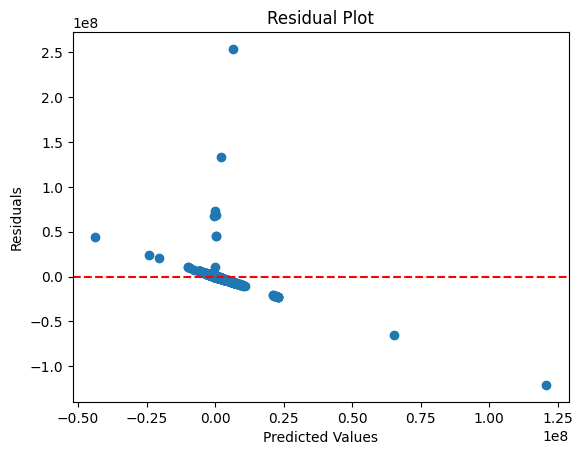

In [69]:
from sklearn.metrics import root_mean_squared_error
root_mean_squared_error(y_test, y_pred)
residuals = y_test - y_pred

# Plot the residuals
plt.scatter(y_pred, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()